**Part 3 - Looseness prediction**

Paulo Yoshio Kuga

In [20]:
import pandas as pd
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import re
import ast



from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

*1. Extract features that might be relevant for distinguishing between a healthy and loose asset. Plot the features from the dataset using any data visualization you find relevant.*

First, we load the metadata, and using it, we can load the real data.

In [21]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

dataDict = {sample_id: pd.read_csv(path + "data/" + sample_id + ".csv") for sample_id in metadata["sample_id"]}

for i,file in metadata.iterrows():
    data = dataDict[file["sample_id"]]
    data.set_index("X-Axis", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictChannel[name]] for name in data.columns]

    

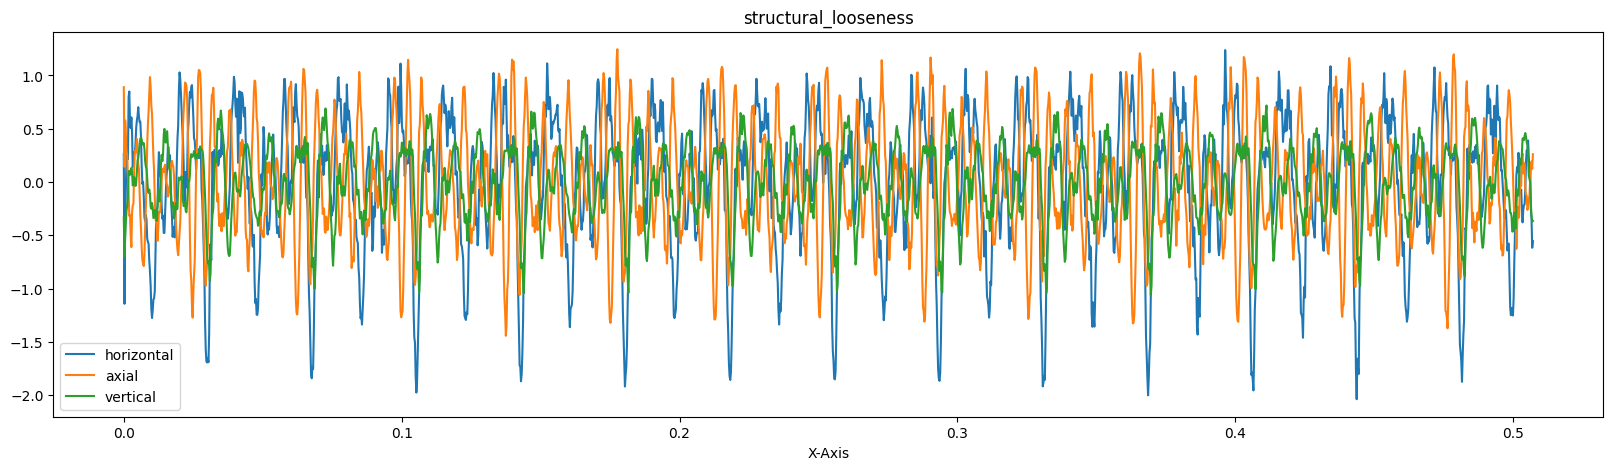

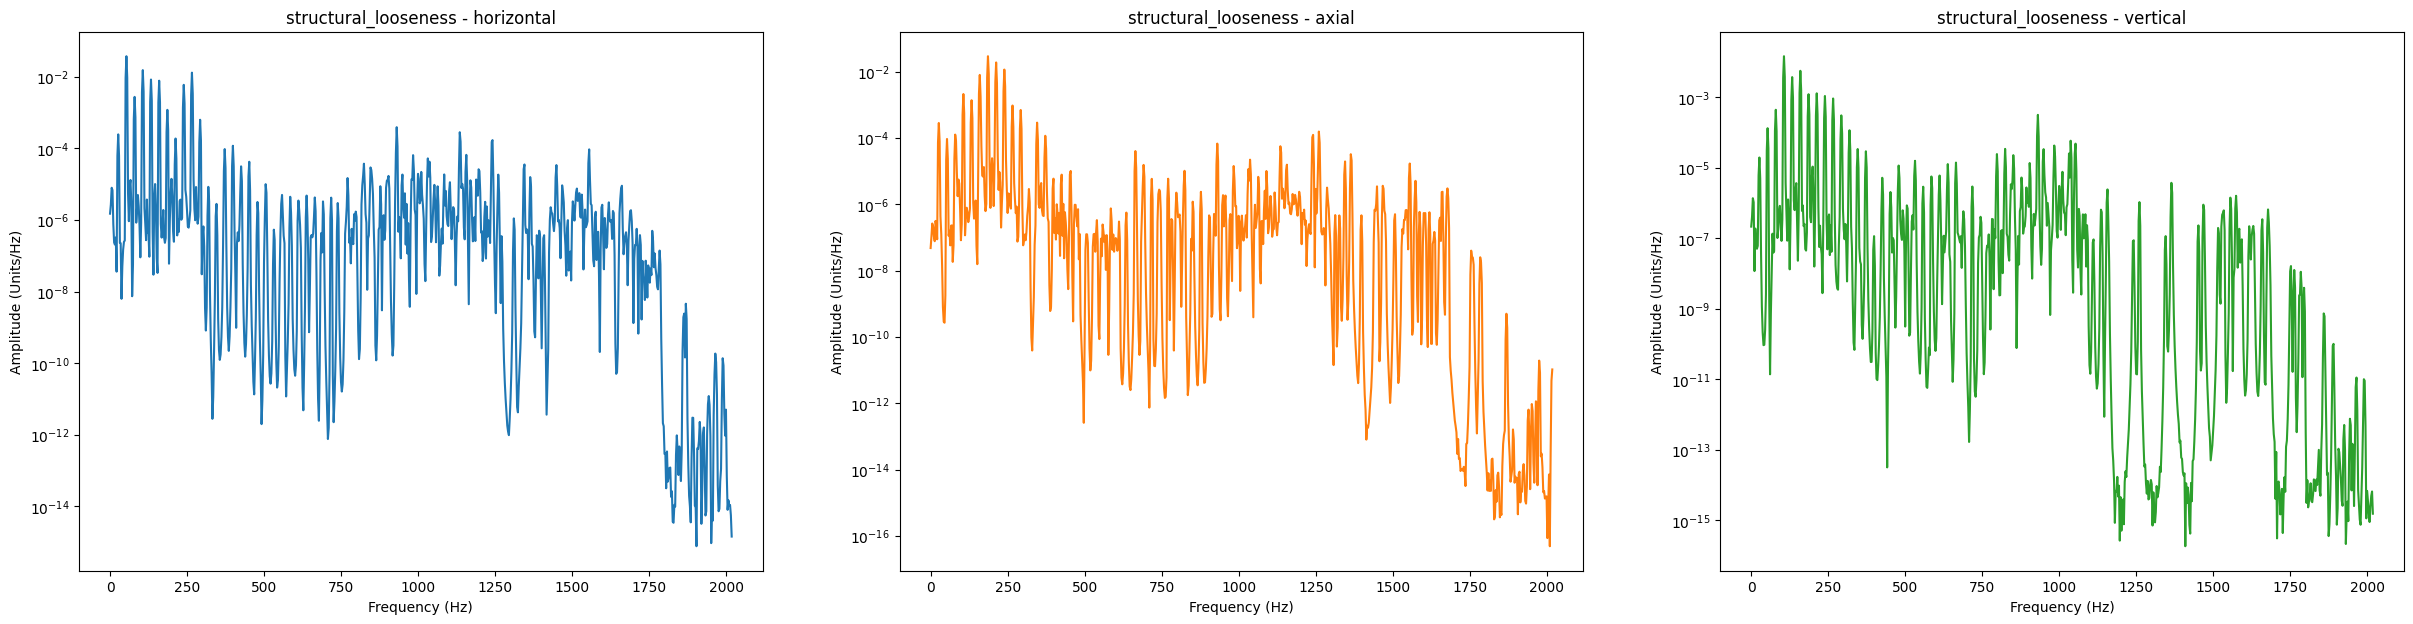

In [22]:
i =121

windowP = "hann"

data = dataDict[metadata["sample_id"][i]]
data = data - data.mean()
fs = data.shape[0] / data.index.max() 

f_fund = metadata["rpm"][i]/60 #the fundamental frequency. it is expected this frequency to appear in the spectrum

m =10  #intervals around the fundamental frequency

w = fs*m/(metadata["rpm"][i]/60)

data.plot(figsize=(20,5))
plt.title(metadata["condition"][i])


f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
_, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
_, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')

P_g = np.array([Ph, Pa, Pv])

fig, axs = plt.subplots(1, 3, figsize=(30, 7))
for j, ax in enumerate(axs):
    ax.semilogy(f, P_g[j], color='C'+str(j))
    ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')

In [23]:
fn = fs/2

lastHarmonic = int(np.ceil(fn/f_fund)) #last harmonic before Nyquist freq

harmonics = np.array([n*f_fund for n in range(1,lastHarmonic)])

def locateHarmonics(f,fh):
    return np.array([np.argmin(np.abs(f-f_harm)) for f_harm in fh])

harmonicsInFreq = locateHarmonics(f,harmonics) #same as range(m,(lastHarmonic)*m,m)

In [24]:
np.log10(np.sum(P_g[:,harmonicsInFreq]*(f[1]-f[0]),axis=1))

array([-0.59938555, -0.70804716, -1.09853109])

In [25]:
def Energy(data,f_fund,m=5,windowP="hann"):
    
    data = data - data.mean()
    fs = data.shape[0] / data.index.max() 
   
    w = fs*m/f_fund
    
    f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
    _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
    _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')

    P_g = np.array([Ph, Pa, Pv])

    fn = fs/2

    lastHarmonic = int(np.ceil(fn/f_fund)) #last harmonic before Nyquist freq

    harmonics = np.array([n*f_fund for n in range(1,lastHarmonic)])

    harmonicsInFreq = locateHarmonics(f,harmonics) #same as range(m,(lastHarmonic)*m,m)

    return np.log10(np.sum(P_g[:,harmonicsInFreq]*(f[1]-f[0]),axis=1))

In [26]:
def get_energies(sample_id,rpm):
    return pd.Series(Energy(dataDict[sample_id],rpm/60), index=["Eh","Ea","Ev"])


EnergyData = pd.DataFrame(index=metadata.index,columns=["Eh","Ea","Ev"])
for i,rows in metadata.iterrows():
    #["sample_id","rpm","condition"]
    sample_id = rows["sample_id"]
    rpm = rows["rpm"]
    
    EnergyData.iloc[i,:] = Energy(dataDict[sample_id],rpm/60)

EnergyData["condition"] = metadata["condition"].copy()

X = EnergyData[["Eh","Ea","Ev"]]
y = EnergyData["condition"]
           
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=199712115)

In [27]:
pipeToKnn = Pipeline(    
    steps=[
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier()
         )
         ]
)


#parameters to be tested
param_grid = {
    "knn__n_neighbors": np.array(list(range(1, 30))),  
    "knn__weights": ["uniform", "distance"]
}

# otimizador com validação cruzada
grid = GridSearchCV(
    pipeToKnn,
    param_grid,
    cv=5, #10 fold had not changed f1                 
    scoring="f1_macro" #macro or weighted?
)

grid.fit(X_train, y_train)

pipeToKnn.set_params(**grid.best_params_)

print("Parameters:", grid.best_params_)
print("F1 Score:", grid.best_score_)

Parameters: {'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
F1 Score: 0.9622341496830952


In [28]:
pipeToKnn.fit(X_train,y_train)

y_hat = pipeToKnn.predict(X_test)

#how to score: pipeToKnn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_hat))

                      precision    recall  f1-score   support

             healthy       0.95      0.95      0.95        20
structural_looseness       0.98      0.98      0.98        43

            accuracy                           0.97        63
           macro avg       0.96      0.96      0.96        63
        weighted avg       0.97      0.97      0.97        63



In [29]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")

    
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed

        defaultParams = {"threshold_PeakFrequency":150,
                         "windowP":"hann",
                         "nperseg":512,
                         "noverlap":256,
                         "rolling_window_size":8,
                         "n_neighbors":4,
                         "weights":"distance"
                         }
    
        self.params = {**defaultParams, **params}


        
        self.Model = Pipeline(    
            steps=[
                ("scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=self.params["n_neighbors"],weights=self.params["weights"])
                )
                ]
        )
        
    def _EnergyGen(data,f_fund,m=5,windowP="hann"):
        
        data = data - data.mean()
        fs = data.shape[0] / data.index.max() 
    
        w = fs*m/f_fund
        
        f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
        _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')
        _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=w, noverlap=w//2, scaling='density',average='median')

        P_g = np.array([Ph, Pa, Pv])

        fn = fs/2

        lastHarmonic = int(np.ceil(fn/f_fund)) #last harmonic before Nyquist freq

        harmonics = np.array([n*f_fund for n in range(1,lastHarmonic)])

        harmonicsInFreq = locateHarmonics(f,harmonics) #same as range(m,(lastHarmonic)*m,m)

        return np.log10(np.sum(P_g[:,harmonicsInFreq]*(f[1]-f[0]),axis=1))

    def fit(self,X_train, y_train):      
        self.Model.fit(X_train, y_train)

    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:

        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """

        self._EnergyGen(wave_hor, wave_ver, wave_axi)
        Adequation = pd.DataFrame(self.Energy,columns=["Eh","Ev","Ea"])

        prediction = self.Model.predict(Adequation)[0] == 'structural_looseness'


        return prediction
               
        
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        self._EnergyGen(wave_hor, wave_ver, wave_axi)

        Adequation = pd.DataFrame(self.Energy,columns=["Eh","Ev","Ea"])

        
        return self.Model.predict_proba(Adequation)[:,1]

In [30]:
test_metadata = pd.read_csv(path+"test_metadata.csv")
testDataDict = {sample_id: pd.read_csv(path + "test_data/" + sample_id + ".csv") for sample_id in test_metadata["sample_id"]}


dictTestChannel = {'x': 'axisX', 'y': 'axisY','z': 'axisZ','t':"time"}

for i,file in test_metadata.iterrows():
    data = testDataDict[file["sample_id"]]
    data.set_index("t", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictTestChannel[name]] for name in data.columns]


def WaveConverter(data):
    t = data.index
    return Wave(time=t, signal = data["horizontal"]), Wave(time=t, signal = data["vertical"]), Wave(time=t, signal = data["axial"])

In [31]:
testEnergyData = pd.DataFrame(index=test_metadata.index,columns=["Eh","Ea","Ev"])
for i,rows in test_metadata.iterrows():
    #["sample_id","rpm","condition"]
    sample_id = rows["sample_id"]
    rpm = rows["rpm"]
    
    testEnergyData.iloc[i,:] = Energy(testDataDict[sample_id],rpm/60)



In [32]:
pipeToKnn.predict_proba(testEnergyData)

array([[0. , 1. ],
       [0.5, 0.5],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

In [33]:
loosenessModel = LoosenessModel()
loosenessModel.fit(X,y)

def modelPrediction(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.predict(Wh,Wv,Wa)

def modelScore(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.score(Wh,Wv,Wa)

test_metadata["prediction"] = test_metadata["sample_id"].apply(modelPrediction)
test_metadata["score"] = test_metadata["sample_id"].apply(modelScore)



AttributeError: 'LoosenessModel' object has no attribute 'mean'

In [ ]:
test_metadata

,asset,sample_id,rpm,orientation,prediction,score
0,electric-motor,33542920-30ea-5844-861d-2c82d79087b8,1170,"{'axisX': 'vertical', 'axisY': 'horizontal', '...",False,[0.0]
1,spindle,e057600e-3b4e-58ba-b8b8-357169ae6bf6,1800,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,[0.0]
2,bearing,01e98ad9-23c9-5986-ace0-4519bad71198,1785,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,[0.0]
3,fan,2211750b-6672-5a94-bd40-cda811f69d01,2025,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,[0.0]
4,compressor,680bbcbf-b1c8-544d-8f80-bf763cdcd128,3573,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",False,[0.0]
5,compressor,1dab1534-b8a8-5962-b01c-bff0782d54a9,3545,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",False,[0.0]
6,bearing,9f3b933a-1bc3-5093-9dee-800cc03c6b1d,1590,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,[0.0]
